# <b>FORECASTING AVOCADO PRICES USING FACEBOOK PROPHET </b>

- Prophet is open source software released by Facebook’s Core Data Science team.

- Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

- Prophet works best with time series that have strong seasonal effects and several seasons of historical data.



# STEP #0: PROBLEM STATEMENT
###To forecast Avocado prices using Prophet Time Series

- Data represents weekly 2018 retail scan data for National retail volume (units) and price.
- Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados.
- The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags.
- The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

Some relevant columns in the dataset:

- Date - The date of the observation
- AveragePrice - the average price of a single avocado
- type - conventional or organic
- year - the year
- Region - the city or region of the observation
- Total Volume - Total number of avocados sold
- 4046 - Total number of avocados with PLU 4046 sold
- 4225 - Total number of avocados with PLU 4225 sold
- 4770 - Total number of avocados with PLU 4770 sold



# STEP #1: IMPORTING DATA

In [92]:
# import libraries
import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import random
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error


In [93]:
# dataframes creation for both training and testing datasets
avocado_df = pd.read_csv('avocado.csv')


# STEP #2: EXPLORING THE DATASET  

In [94]:
# Let's view the head of the training dataset
avocado_df.head()

,,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,27/12/2015,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,20/12/2015,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,13/12/2015,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,06/12/2015,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,29/11/2015,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [95]:
# Let's view the last elements in the training dataset
avocado_df.tail()

,,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
18244,7,04/02/2018,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,28/01/2018,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,21/01/2018,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,14/01/2018,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico
18248,11,07/01/2018,1.62,17489.58,2894.77,2356.13,224.53,12014.15,11988.14,26.01,0.0,organic,2018,WestTexNewMexico


In [96]:
avocado_df = avocado_df.sort_values("Date")

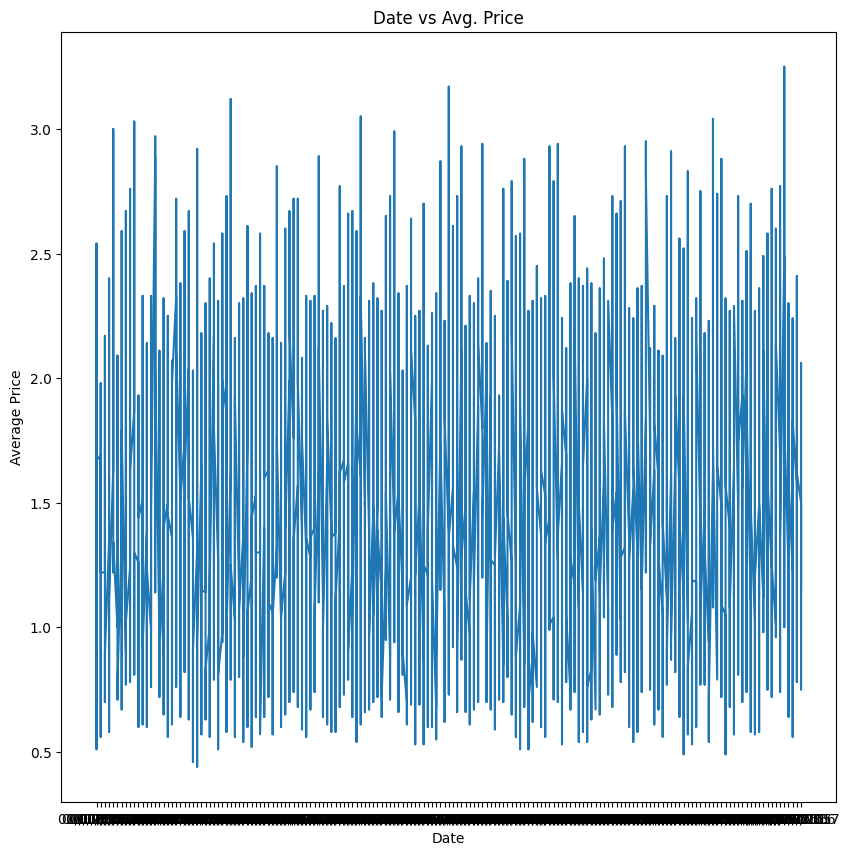

In [97]:
plt.figure(figsize=(10,10))
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.title("Date vs Avg. Price")
plt.plot(avocado_df['Date'], avocado_df['AveragePrice'])


## Inference:

- The average price exhibits significant volatility and fluctuations over time, with numerous peaks and troughs observed throughout the plotted period.
- The overall trend seems to indicate cyclical or seasonal patterns, with the average price rising and falling within a certain range repeatedly.
- There are periods where the average price remains relatively stable, with minimal fluctuations, interspersed with periods of higher volatility and larger price swings.

In [98]:
avocado_df

,,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
7470,52,01/01/2017,1.02,141043.91,58724.08,42203.79,2553.37,37562.67,28298.47,9264.20,0.00,conventional,2017,Pittsburgh
16542,52,01/01/2017,1.88,7740.98,2155.99,3030.64,1.20,2553.15,2547.83,5.32,0.00,organic,2017,PhoenixTucson
15747,52,01/01/2017,1.40,10109.46,7550.89,58.71,0.00,2499.86,2499.86,0.00,0.00,organic,2017,Houston
7682,52,01/01/2017,1.11,240752.75,82444.88,85577.58,5485.61,67244.68,65961.19,1104.32,179.17,conventional,2017,RichmondNorfolk
6410,52,01/01/2017,0.77,306129.40,1217.67,224774.25,7582.69,72554.79,68737.04,3714.24,103.51,conventional,2017,GrandRapids
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7736,0,31/12/2017,1.03,578374.50,130774.36,396250.81,922.03,50427.30,46215.90,521.92,3689.48,conventional,2017,Sacramento
16278,0,31/12/2017,1.66,229313.64,11281.04,33549.86,122.83,184359.91,170878.67,13481.24,0.00,organic,2017,Northeast
6199,0,31/12/2017,0.90,1116393.20,481105.48,307423.18,4818.24,323046.30,161254.88,161616.45,174.97,conventional,2017,DallasFtWorth
7577,0,31/12/2017,0.92,419590.58,90432.19,134861.05,5994.91,188302.43,178330.99,9970.33,1.11,conventional,2017,RaleighGreensboro


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53],
 [Text(0, 0, 'Pittsburgh'),
  Text(1, 0, 'PhoenixTucson'),
  Text(2, 0, 'Houston'),
  Text(3, 0, 'RichmondNorfolk'),
  Text(4, 0, 'GrandRapids'),
  Text(5, 0, 'Atlanta'),
  Text(6, 0, 'Spokane'),
  Text(7, 0, 'Albany'),
  Text(8, 0, 'GreatLakes'),
  Text(9, 0, 'HartfordSpringfield'),
  Text(10, 0, 'Plains'),
  Text(11, 0, 'West'),
  Text(12, 0, 'Portland'),
  Text(13, 0, 'HarrisburgScranton'),
  Text(14, 0, 'BaltimoreWashington'),
  Text(15, 0, 'California'),
  Text(16, 0, 'RaleighGreensboro'),
  Text(17, 0, 'Roanoke'),
  Text(18, 0, 'SanFrancisco'),
  Text(19, 0, 'Indianapolis'),
  Text(20, 0, 'WestTexNewMexico'),
  Text(21, 0, 'Southeast'),
  Text(22, 0, 'Detroit'),
  Text(2

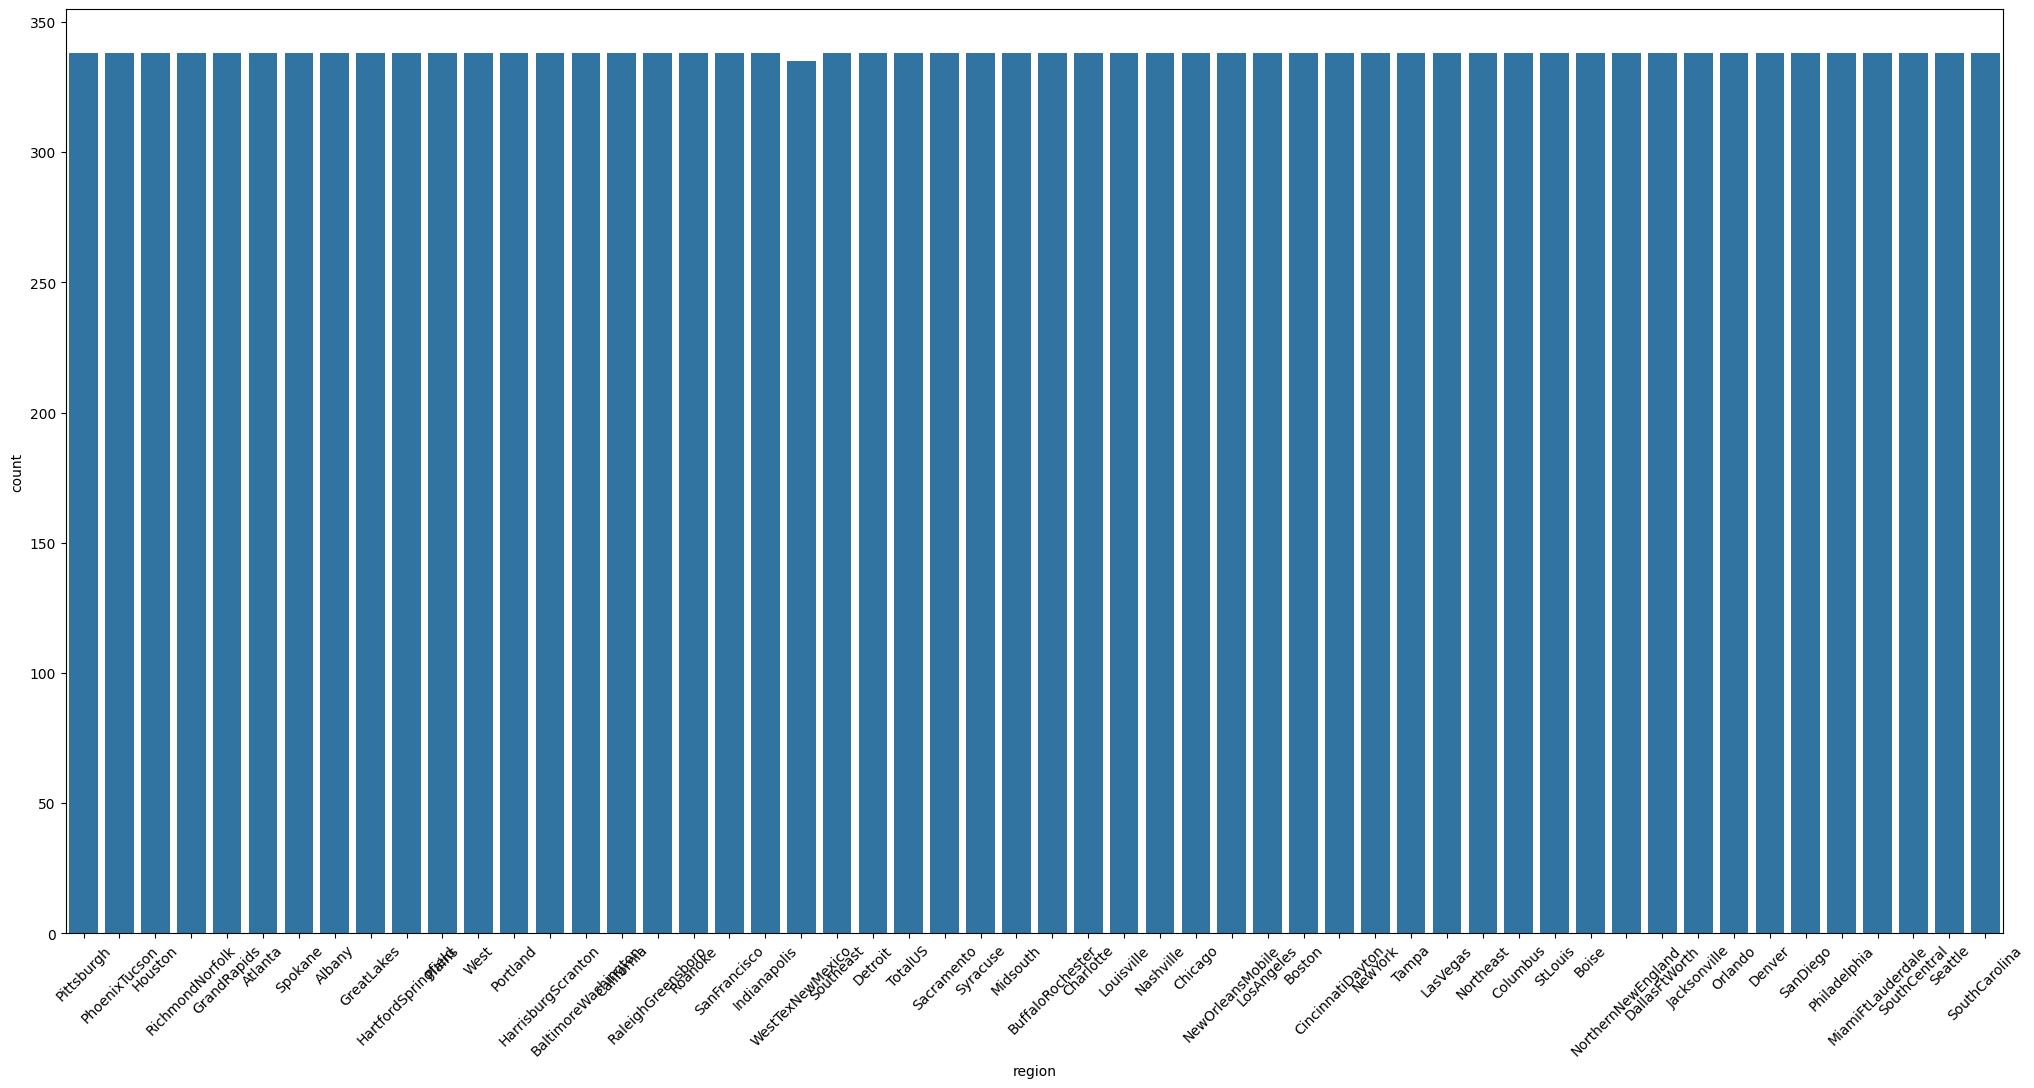

In [99]:
# Bar Chart to indicate the number of regions
plt.figure(figsize=[25,12])
sns.countplot(x = 'region', data = avocado_df)
plt.xticks(rotation = 45)


## Inference:

- The graph shows constant values across all regions, as indicated by the uniform height of the bars.
- With only a single constant value shown, it is difficult to draw meaningful insights or comparisons between regions based solely on this graph.

([0, 1, 2, 3],
 [Text(0, 0, '2015'),
  Text(1, 0, '2016'),
  Text(2, 0, '2017'),
  Text(3, 0, '2018')])

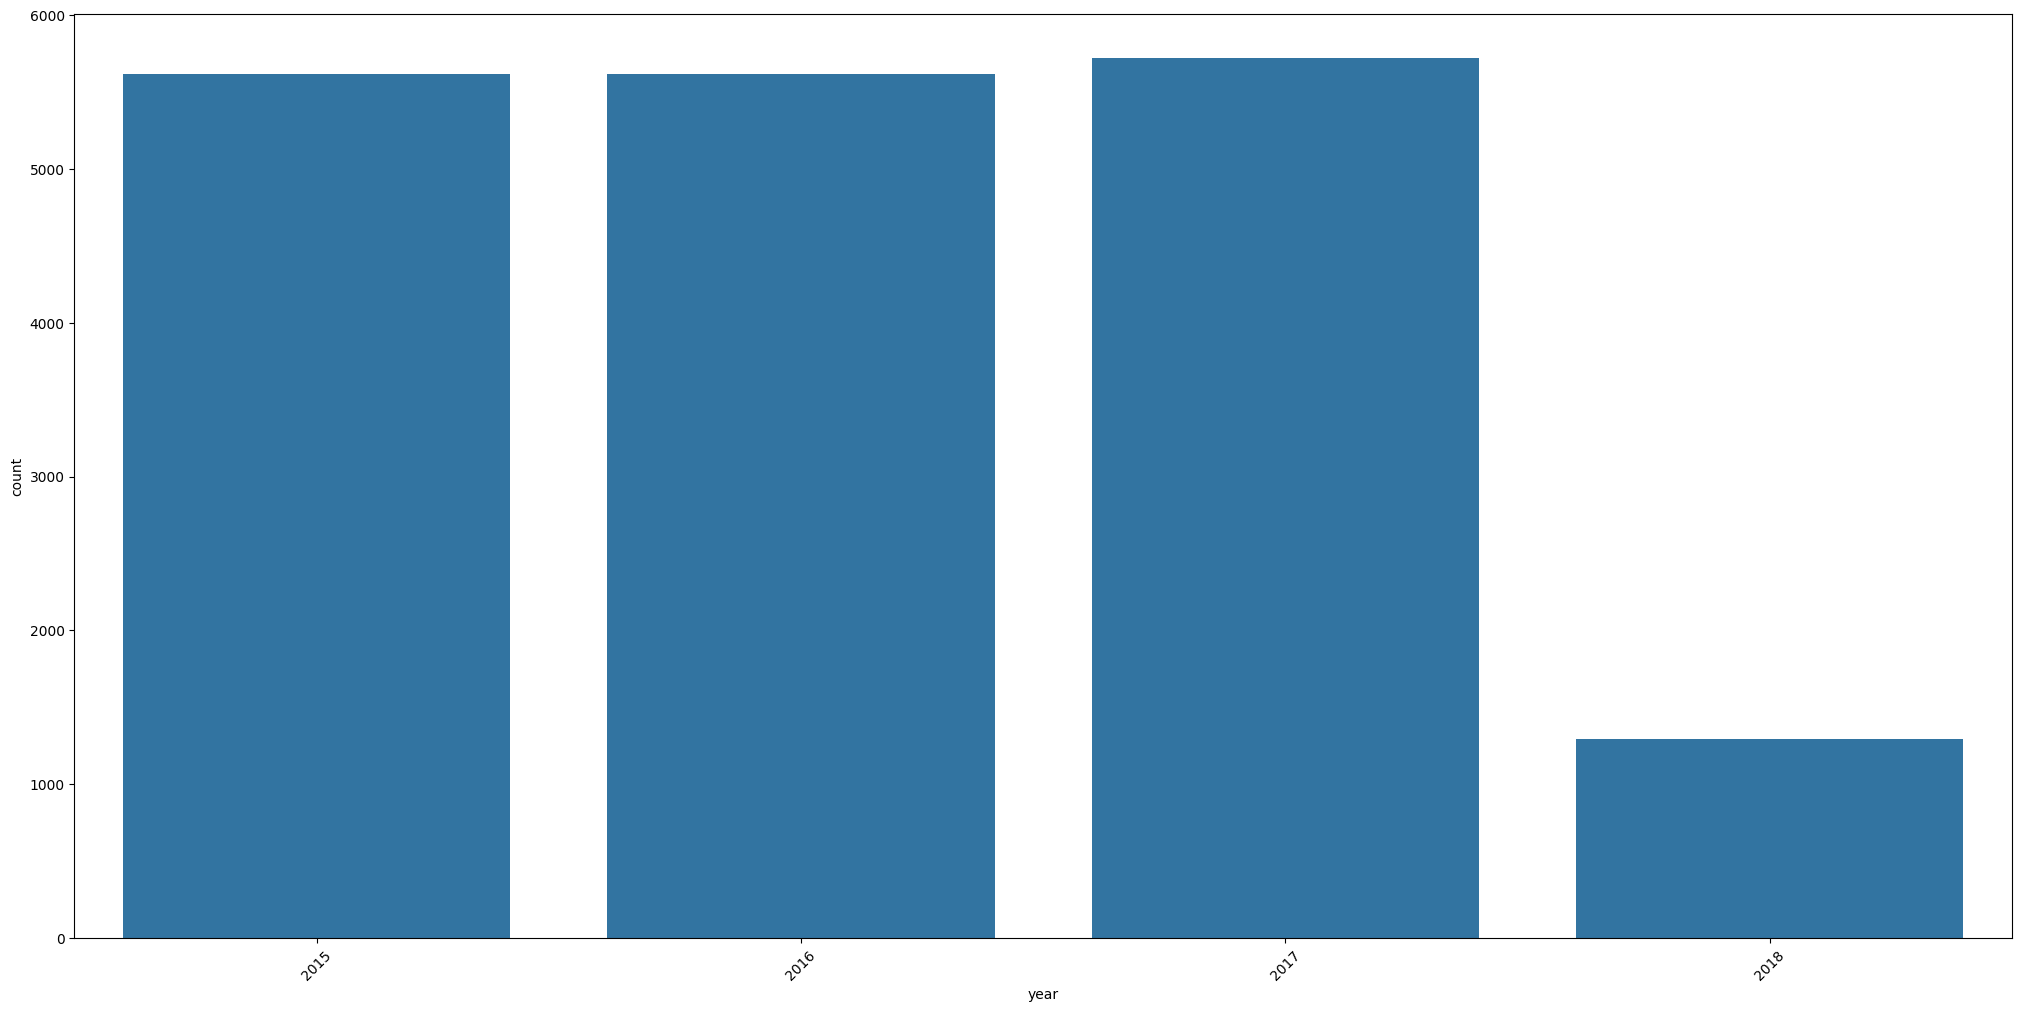

In [100]:
# Bar Chart to indicate the year
plt.figure(figsize=[25,12])
sns.countplot(x = 'year', data = avocado_df)
plt.xticks(rotation = 45)


## Inference:

- The height of the bars increases progressively from 2015 to 2017, suggesting an upward trend or growth in the values over those years.
- Potential Peak and Decline: While the value for 2017 is the highest, the bar for 2018 is noticeably shorter, implying a potential peak in 2017 followed by a decline or decrease in the value for 2018.

In [101]:
avocado_prophet_df = avocado_df[['Date', 'AveragePrice']]


In [102]:
avocado_prophet_df

,Date,AveragePrice
7470,01/01/2017,1.02
16542,01/01/2017,1.88
15747,01/01/2017,1.40
7682,01/01/2017,1.11
6410,01/01/2017,0.77
...,...,...
7736,31/12/2017,1.03
16278,31/12/2017,1.66
6199,31/12/2017,0.90
7577,31/12/2017,0.92


Here, we've created a new database with only relevant features for our database, i.e., Date and Price

# STEP 3: MAKE PREDICTIONS

In [103]:
avocado_prophet_df = avocado_prophet_df.rename(columns={'Date':'ds', 'AveragePrice':'y'})


In [104]:
avocado_prophet_df

,ds,y
7470,01/01/2017,1.02
16542,01/01/2017,1.88
15747,01/01/2017,1.40
7682,01/01/2017,1.11
6410,01/01/2017,0.77
...,...,...
7736,31/12/2017,1.03
16278,31/12/2017,1.66
6199,31/12/2017,0.90
7577,31/12/2017,0.92


In Prophet Time Series, it is necessary to only have two attritbutes 'ds' and 'y'. 'ds' represents the date and 'y' represents the target variable or dependent variable. No other column names are accepted other than these.

In [105]:
# Creating an object and fitting the model
m = Prophet()
m.fit(avocado_prophet_df)


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1133: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  self.history_dates = pd.to_datetime(pd.Series(history['ds'].unique(), name='ds')).sort_values()
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:287: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp_5m5kt4/42jxu4lg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp_5m5kt4/1vqwmm26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/pyt

In [106]:
# Forcasting into the future
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

- The make_future_dataframe function lets you specify the frequency and number of periods you would like to forecast into the future. By default, the frequency is set to days. Since we are using daily periodicity data in this example, we will leave freq at it’s default and set the periods argument to 365, indicating that we would like to forecast 365 days into the future.
- We have then used the predict method to make predictions for each row in the future dataframe.

In [107]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,1.418784,0.787832,1.808106,1.418784,1.418784,-0.110694,-0.110694,-0.110694,-0.040912,-0.040912,-0.040912,-0.069782,-0.069782,-0.069782,0.0,0.0,0.0,1.308090
1,2015-01-03,1.418467,0.821092,1.790513,1.418467,1.418467,-0.109915,-0.109915,-0.109915,-0.043383,-0.043383,-0.043383,-0.066532,-0.066532,-0.066532,0.0,0.0,0.0,1.308552
2,2015-01-11,1.415931,0.863431,1.889487,1.415931,1.415931,-0.037691,-0.037691,-0.037691,0.014705,0.014705,0.014705,-0.052396,-0.052396,-0.052396,0.0,0.0,0.0,1.378240
3,2015-01-18,1.413711,0.872573,1.838450,1.413711,1.413711,-0.042408,-0.042408,-0.042408,0.014705,0.014705,0.014705,-0.057112,-0.057112,-0.057112,0.0,0.0,0.0,1.371304
4,2015-01-25,1.411492,0.905341,1.885511,1.411492,1.411492,-0.039908,-0.039908,-0.039908,0.014705,0.014705,0.014705,-0.054613,-0.054613,-0.054613,0.0,0.0,0.0,1.371584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,2019-10-30,0.962722,0.553670,1.575382,0.880154,1.047392,0.098734,0.098734,0.098734,-0.031261,-0.031261,-0.031261,0.129996,0.129996,0.129996,0.0,0.0,0.0,1.061456
530,2019-10-31,0.962001,0.662068,1.704347,0.879060,1.047031,0.223058,0.223058,0.223058,0.095001,0.095001,0.095001,0.128057,0.128057,0.128057,0.0,0.0,0.0,1.185059
531,2019-11-01,0.961279,0.551586,1.556498,0.877966,1.046568,0.084037,0.084037,0.084037,-0.040912,-0.040912,-0.040912,0.124949,0.124949,0.124949,0.0,0.0,0.0,1.045316
532,2019-11-02,0.960557,0.546761,1.552788,0.876872,1.046069,0.077363,0.077363,0.077363,-0.043383,-0.043383,-0.043383,0.120746,0.120746,0.120746,0.0,0.0,0.0,1.037921


Prophet is an additive model consisting of four main components:

<img src="https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Time-Series-Prediction_11.png?ssl=1" alt="Alternative text" />

Here,

- g(t) refers to trend (changes over a long period of time)
- s(t) refers to seasonality (periodic or short-term changes)
- h(t) refers to effects of holidays to the forecast
- e(t) refers to the unconditional changes that is specific to a business or a person or a circumstance. It is also called the error term.
- y(t) is the forecast.

This new dataframe contains yhat the predicted values of future dates as well as uncertainty intervals and components for the forecast.

Using time as a regressor, Prophet is trying to fit several linear and non linear functions of time as components. Modeling seasonality as an additive component is the same approach taken by exponential smoothing in Holt-Winters technique.


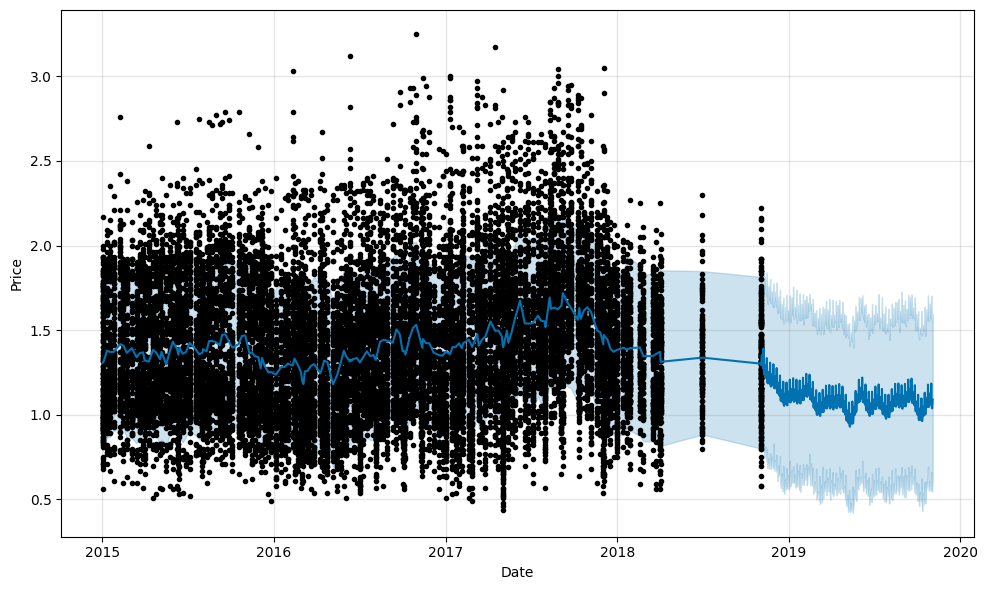

In [108]:
figure = m.plot(forecast, xlabel='Date', ylabel='Price')

## Inferences:

1. Two Data Patterns: There are two distinct patterns visible in the data. The first pattern, represented by the dense black scatter points, seems to be the historical data used for training the forecasting model. The second pattern, shown in blue, appears to be the forecast generated by the Prophet model.

2. High Volatility in Historical Data: The historical data (black scatter points) exhibits a high degree of volatility and fluctuations, suggesting that the underlying time series being modeled has significant variability.

3. Seasonal Pattern: The forecast (blue line) shows a distinct seasonal or cyclical pattern, with regular peaks and troughs repeating over time. This implies that the Prophet model has captured and projected the seasonal components present in the historical data.

4. Increasing Trend: While the forecast fluctuates seasonally, there seems to be an overall increasing trend in the predicted values, suggesting that the time series being modeled has an underlying upward trajectory.

5. Uncertainty Intervals: The vertical black lines accompanying the forecast represent the uncertainty intervals or confidence intervals associated with the predictions. These intervals appear to be relatively narrow, indicating a higher level of confidence in the forecast.

6. Outliers in Forecast: There are a few isolated spikes or outliers in the forecast, which could represent exceptional events or anomalies that the Prophet model has identified and incorporated into the predictions.

Overall, the Prophet forecast graph suggests that the underlying time series exhibits significant volatility and seasonality, with an increasing trend over time. The Prophet model has captured these patterns and generated a forecast that incorporates the seasonal fluctuations while projecting an overall upward trajectory, accounting for potential outliers or exceptional events.

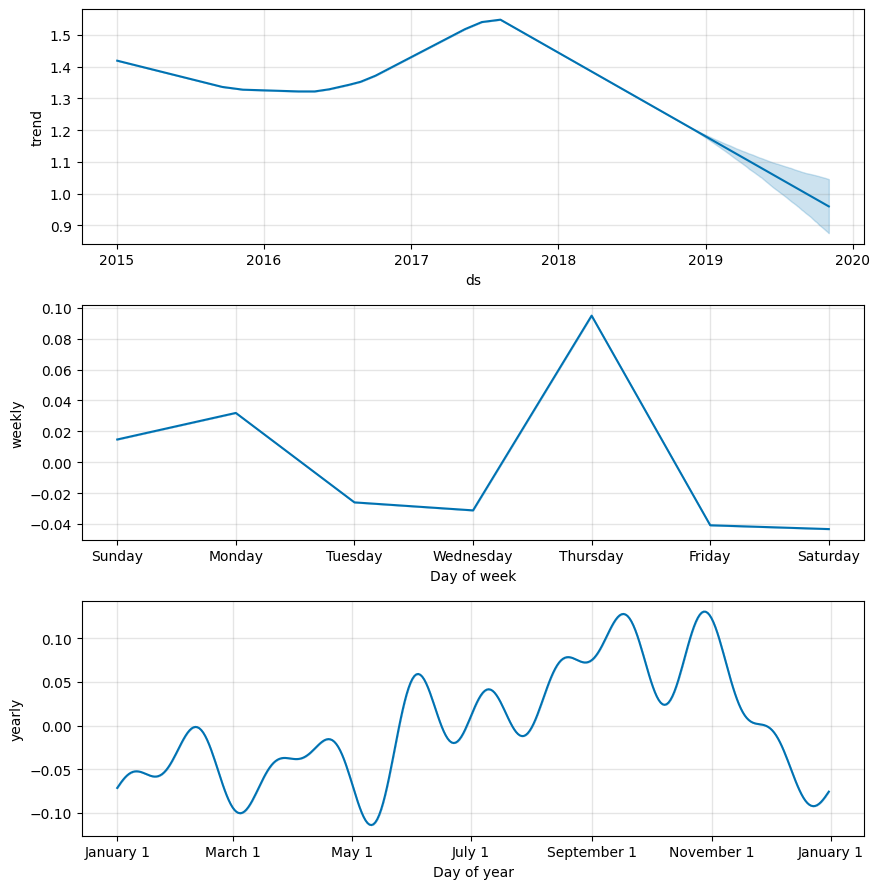

In [109]:
figure3 = m.plot_components(forecast)

## Inferences:

Trend Inference:
1. Overall Trend: The upper plot shows the overall trend of the time series data. It exhibits a distinct yearly cycle with a peak around mid-year (likely summer months) and a trough towards the end of the year (likely winter months). This pattern suggests a seasonal or cyclical behavior in the data.

2. Decreasing Trend: While the seasonal pattern is evident, there is also an apparent decreasing trend in the overall level of the time series from 2015 to 2020. This indicates that the underlying phenomenon being modeled is experiencing a gradual decline over the years.

Weekly Inference:
3. Weekly Seasonality: The middle plot displays the weekly seasonal pattern in the data. It shows a clear weekly cycle, with a peak around mid-week (Wednesday/Thursday) and lower values on weekends. This pattern suggests that the time series is influenced by weekly patterns, potentially related to human activities or business cycles.

4. Weekend Dip: The plot shows a distinct dip in values on Sundays, indicating a consistent lower level of activity or demand on that day of the week compared to other days.

Yearly Inference:
5. Yearly Seasonality: The lower plot reveals the yearly seasonal pattern in the data. It shows a distinct yearly cycle, with peaks around mid-year (likely summer months) and troughs towards the end of the year (likely winter months). This pattern aligns with the overall trend observed in the upper plot, confirming the presence of a strong yearly seasonality.

6. Irregular Patterns: While the yearly seasonal pattern is evident, there are also some irregular fluctuations and deviations from the smooth curve, suggesting the presence of additional factors or events influencing the time series beyond the regular seasonal patterns.

Overall, the Prophet forecast graph indicates that the time series being modeled exhibits strong yearly and weekly seasonal patterns, with peaks in summer and mid-week, respectively. Additionally, there is an overall decreasing trend in the data from 2015 to 2020, suggesting a gradual decline in the underlying phenomenon. The presence of irregular fluctuations in the lower plot suggests the influence of additional factors beyond the regular seasonal patterns.

## PERFORMANCE EVALUATION

In [110]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

df_cv.head()



INFO:prophet:Making 2 forecasts with cutoffs between 2017-05-07 00:00:00 and 2017-11-03 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpp_5m5kt4/67akasqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp_5m5kt4/fn82_wjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6038', 'data', 'file=/tmp/tmpp_5m5kt4/67akasqq.json', 'init=/tmp/tmpp_5m5kt4/fn82_wjx.json', 'output', 'file=/tmp/tmpp_5m5kt4/prophet_model_s_da3j3/prophet_model-20240403202929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:29:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:29:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp_5m5kt4/35m0gnp5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp_5m5kt4/jagul9zc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-05-11,1.506443,1.001609,2.014186,0.79,2017-05-07
1,2017-05-11,1.506443,0.967885,1.987173,1.84,2017-05-07
2,2017-05-11,1.506443,1.008009,1.990539,1.82,2017-05-07
3,2017-05-11,1.506443,1.020578,2.019879,1.28,2017-05-07
4,2017-05-11,1.506443,1.003161,1.968569,0.96,2017-05-07


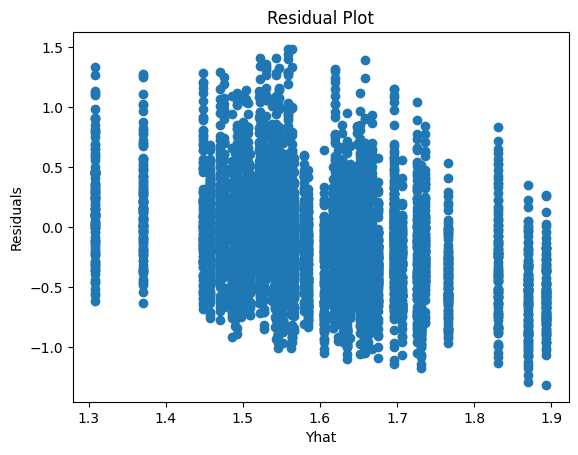

In [206]:
# Residual Graph
residuals = df_cv['y'] - df_cv['yhat']
plt.scatter(df_cv['yhat'],residuals)
plt.xlabel("Yhat")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

## Inference:

From this graph, we can see that our residual values and randomly scatter around 0. This shows that it is a good model.

In [111]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,23 days,0.174982,0.418309,0.331968,0.229853,0.181281,0.218087,0.795479
1,29 days,0.201785,0.449205,0.358156,0.277581,0.197524,0.244249,0.754610
2,30 days,0.214733,0.463393,0.372189,0.301848,0.206265,0.254873,0.734376
3,32 days,0.201298,0.448662,0.363333,0.299080,0.201702,0.246952,0.751152
4,38 days,0.197864,0.444819,0.363067,0.302356,0.204156,0.247354,0.750844


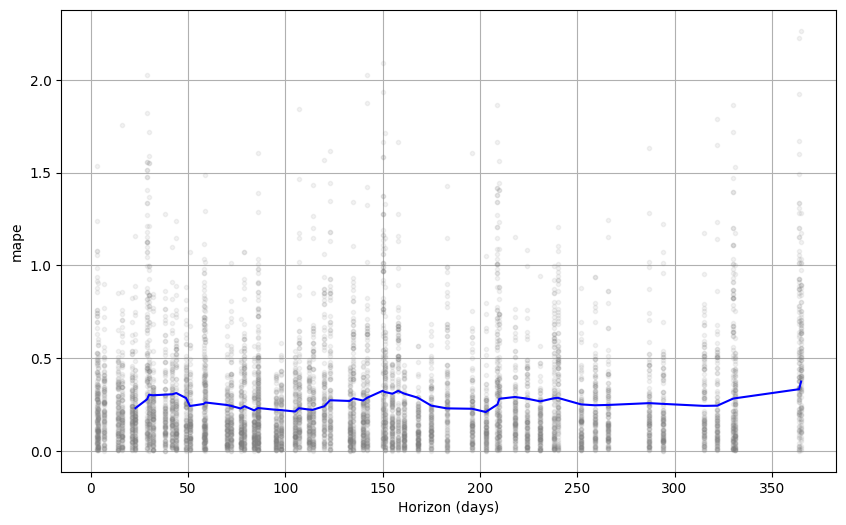

In [112]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

## Inference:

- From this graph we can see that our model has a MAPE ranging from 0.1 to 0.3  over a span of 365 days which makes this a fairly decent model given the resources used to make this model.


# REGION SPECIFIC FORECASTING

In [113]:
# dataframes creation for both training and testing datasets
avocado_df = pd.read_csv('avocado.csv')


In [114]:
avocado_df

,,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,27/12/2015,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,20/12/2015,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,13/12/2015,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,06/12/2015,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,29/11/2015,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,04/02/2018,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,28/01/2018,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,21/01/2018,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,14/01/2018,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [115]:
avocado_df_sample = avocado_df[avocado_df['region']=='West']

In [116]:
avocado_df_sample

,,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
2704,0,27/12/2015,0.83,5291979.63,2038443.68,1717599.45,125254.82,1410681.68,838267.79,567269.76,5144.13,conventional,2015,West
2705,1,20/12/2015,0.88,4737649.03,2017331.24,1314711.00,130849.60,1274757.19,843691.13,417746.45,13319.61,conventional,2015,West
2706,2,13/12/2015,0.85,4899439.92,1798995.46,1596329.01,134101.62,1370013.83,851506.76,517936.19,570.88,conventional,2015,West
2707,3,06/12/2015,0.75,6202513.84,2097720.52,2051392.83,107568.34,1945832.15,1360760.83,582846.33,2224.99,conventional,2015,West
2708,4,29/11/2015,0.99,3719603.21,1461861.54,1216811.00,104219.76,936710.91,688674.00,247318.15,718.76,conventional,2015,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,7,04/02/2018,1.41,283378.47,22474.66,55360.49,133.41,205409.91,70232.59,134666.91,510.41,organic,2018,West
18233,8,28/01/2018,1.80,185974.53,22918.40,33051.14,93.52,129911.47,77822.23,51986.86,102.38,organic,2018,West
18234,9,21/01/2018,1.83,189317.99,27049.44,33561.32,439.47,128267.76,76091.99,51947.50,228.27,organic,2018,West
18235,10,14/01/2018,1.82,207999.67,33869.12,47435.14,433.52,126261.89,89115.78,37133.99,12.12,organic,2018,West


In [117]:
avocado_df_sample

,,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
2704,0,27/12/2015,0.83,5291979.63,2038443.68,1717599.45,125254.82,1410681.68,838267.79,567269.76,5144.13,conventional,2015,West
2705,1,20/12/2015,0.88,4737649.03,2017331.24,1314711.00,130849.60,1274757.19,843691.13,417746.45,13319.61,conventional,2015,West
2706,2,13/12/2015,0.85,4899439.92,1798995.46,1596329.01,134101.62,1370013.83,851506.76,517936.19,570.88,conventional,2015,West
2707,3,06/12/2015,0.75,6202513.84,2097720.52,2051392.83,107568.34,1945832.15,1360760.83,582846.33,2224.99,conventional,2015,West
2708,4,29/11/2015,0.99,3719603.21,1461861.54,1216811.00,104219.76,936710.91,688674.00,247318.15,718.76,conventional,2015,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,7,04/02/2018,1.41,283378.47,22474.66,55360.49,133.41,205409.91,70232.59,134666.91,510.41,organic,2018,West
18233,8,28/01/2018,1.80,185974.53,22918.40,33051.14,93.52,129911.47,77822.23,51986.86,102.38,organic,2018,West
18234,9,21/01/2018,1.83,189317.99,27049.44,33561.32,439.47,128267.76,76091.99,51947.50,228.27,organic,2018,West
18235,10,14/01/2018,1.82,207999.67,33869.12,47435.14,433.52,126261.89,89115.78,37133.99,12.12,organic,2018,West


In [118]:
avocado_df_sample = avocado_df_sample.sort_values("Date")

In [119]:
avocado_df_sample

,,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
17549,52,01/01/2017,1.19,189700.70,20783.06,35758.45,36.46,133122.73,33998.50,99124.23,0.00,organic,2017,West
8424,52,01/01/2017,0.79,7360925.84,2100350.66,1976304.53,123652.12,3160618.53,2299700.47,857388.28,3529.78,conventional,2017,West
11877,47,01/02/2015,1.34,216484.22,89599.59,82183.07,184.99,44516.57,11083.16,33433.41,0.00,organic,2015,West
2751,47,01/02/2015,0.84,8362504.08,3531350.44,3872672.00,80893.53,877588.11,705333.64,172154.91,99.56,conventional,2015,West
11873,43,01/03/2015,1.40,218957.86,110458.55,81474.98,311.88,26712.45,12552.61,14159.84,0.00,organic,2015,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,30,31/05/2015,0.93,5874982.36,3094129.71,1835735.00,129139.05,815978.60,665541.84,150400.52,36.24,conventional,2015,West
14658,21,31/07/2016,1.65,189615.28,50386.72,54278.15,106.15,84844.26,29501.17,55343.09,0.00,organic,2016,West
5533,21,31/07/2016,1.10,5463799.79,1874227.32,1254400.92,95280.92,2239890.63,1730972.57,505626.06,3292.00,conventional,2016,West
8372,0,31/12/2017,0.94,6330634.55,1789024.92,2089553.44,91527.19,2360529.00,1117482.22,1235496.72,7550.06,conventional,2017,West


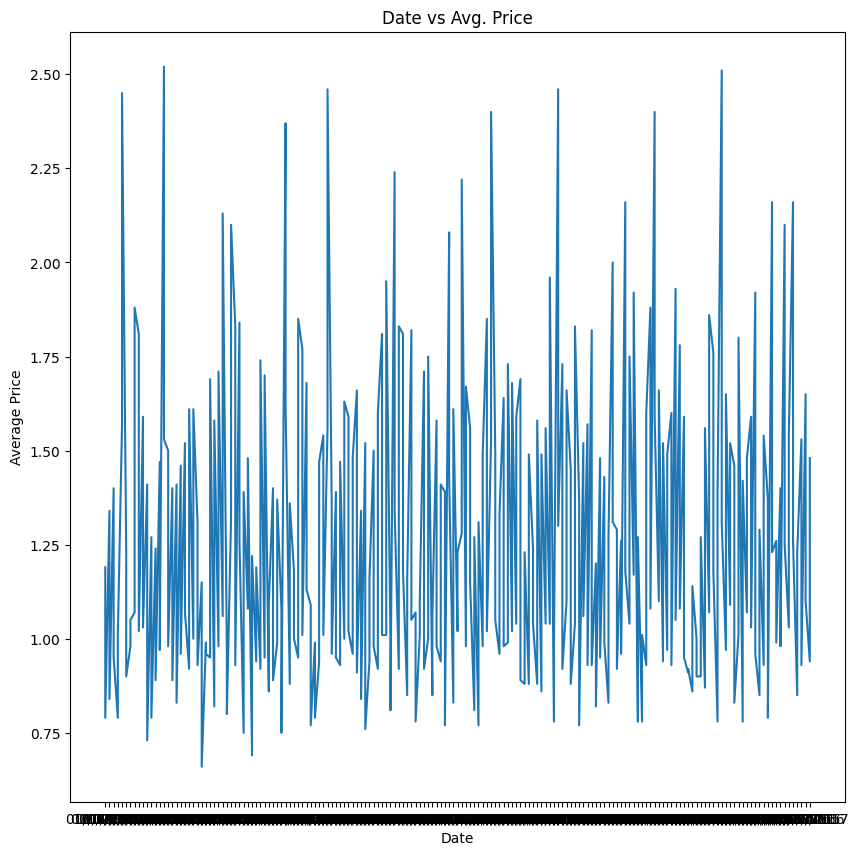

In [120]:
plt.figure(figsize=(10,10))
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.title("Date vs Avg. Price")
plt.plot(avocado_df_sample['Date'], avocado_df_sample['AveragePrice'])

In [121]:
avocado_df_sample = avocado_df_sample.rename(columns={'Date':'ds', 'AveragePrice':'y'})


In [122]:
m = Prophet()
m.fit(avocado_df_sample)
# Forcasting into the future
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1133: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  self.history_dates = pd.to_datetime(pd.Series(history['ds'].unique(), name='ds')).sort_values()
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:287: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['ds'] = pd.to_datetime(df['ds'])
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp_5m5kt4/onptdmvm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp_5m5kt4/gdrywqu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/pyt

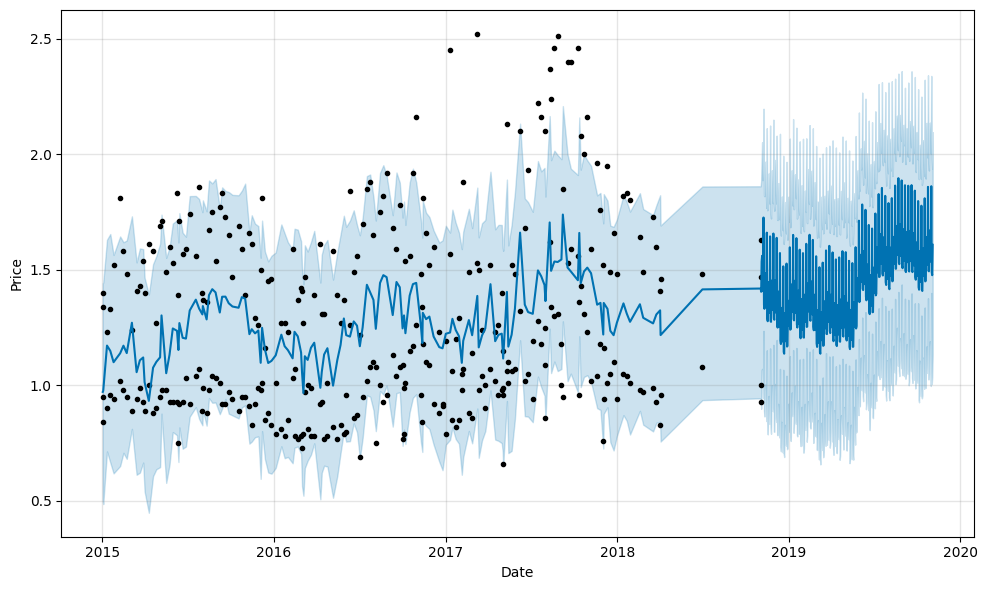

In [123]:
figure = m.plot(forecast, xlabel='Date', ylabel='Price')

## Inferences:

1. There is significant volatility in the prices, with frequent fluctuations and spikes observed throughout the time period.

2. The overall price trend shows an upward trajectory, with prices generally increasing from 2015 to 2020, despite the volatility.

3. The volatility and price spikes seem to be more pronounced towards the latter part of the timeframe, especially in 2019 and 2020 (covid), suggesting increased market uncertainty or turbulence during that period.




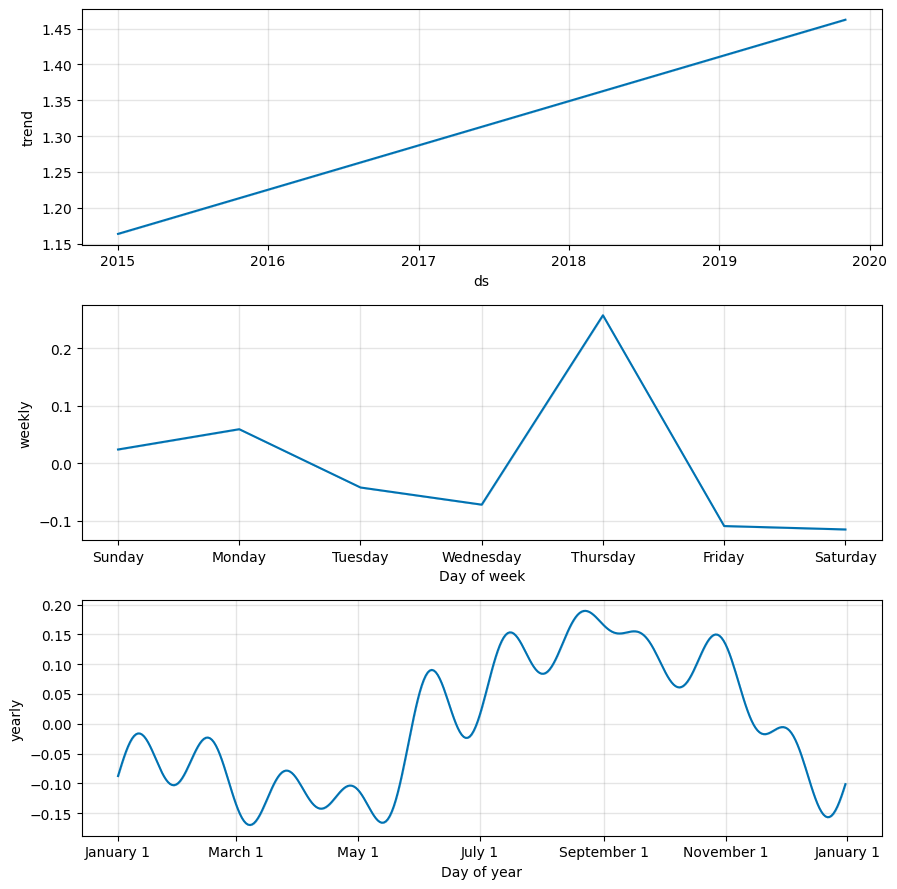

In [124]:
figure3 = m.plot_components(forecast)

# COMPARISION WITH A LINEAR REGRESSION MODEL

Now, let's comapare the same dataset on a Linear Regression model. Even though it might not make sense to make a Linear Model on such data because of such strong seasonality and nonlinear trends. Also because, we will be training the model on different features such as bags sold, total volumne, type of avocados which cannot be pre-determined for a date. The only true feature known is Date, hence it is always advisable to use Time-Series models on such datasets.

In [197]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn. linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [177]:
avocado_lr = pd.read_csv("/content/avocado.csv")
avocado_lr.head()

,,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,27/12/2015,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,20/12/2015,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,13/12/2015,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,06/12/2015,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,29/11/2015,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [178]:
#Changing Categorical data to numerical data
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

avocado_lr['type       ']= label_encoder. fit_transform(avocado_lr['type       '])
avocado_lr['region']= label_encoder. fit_transform(avocado_lr['region'])

In [193]:
# Setting input and output features
X = avocado_lr.drop(["Date","AveragePrice"],axis=1)
y = avocado_lr[["AveragePrice"]].copy()

In [194]:
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

y_pred = lr_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

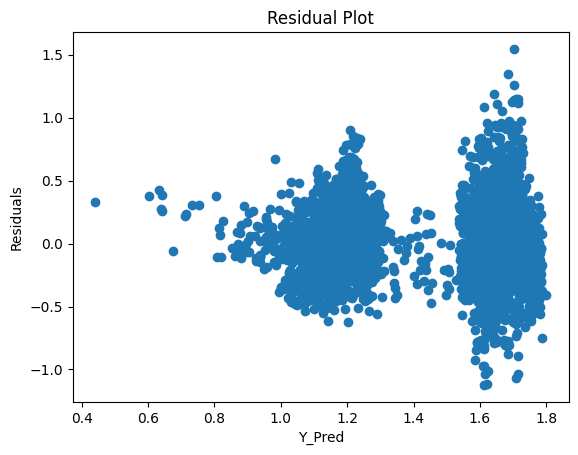

In [207]:
# Residual Graph
residuals = y_test-y_pred
plt.scatter(y_pred,residuals)
plt.xlabel("Y_Pred")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [201]:
print(r2)

0.40925667566177626


## Inference:

- Here we can see that we achieved an accuracy of 0.40 which is fairly poor for a model.